# Setup

This cell checks if `Dedalus` is installed and performs some other basic setup.

If `Dedalus` is not installed and you are using `Google Colab`, it will automatically be installed.
This may take a few minutes the first time you run the notebook, but subsequent sessions during the next day or so should have the installation cached.
No need to worry about the details - **just execute the cell**.

If you are not using `Google Colab`, follow the installation instructions in the [`Dedalus` Docs](https://dedalus-project.readthedocs.io/en/latest/pages/installation.html) to install `Dedalus` locally on your computer.
Installation using `conda` is typically straightforward for Mac and Linux.
No promises on Windows.
Execute the cell to confirm `Dedalus` is installed and importable.

In [1]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:

    import dedalus.public as de
    print("\nDedalus already installed")

except:

    print("\nDedalus not installed yet")

    if using_google_colab:

        print("\nInstalling for Google Colab\n")

        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev

        # Step 2: Set paths for Dedalus installation
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"

        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py < 4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl

        # Step 4: Check installation
        try:
            import dedalus.public as de
            print("\nDedalus was successfully installed. The Google Colab session will now restart")

            import os
            os._exit(0)
        except:
            print("\nError installing Dedalus")
            raise

    else:

        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:

    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1

Dedalus already installed


# Eigenvalue Problems - Shallow Water on the Sphere

**Overview:** This notebook demonstrates how to solve an eigenvalue problem to identify the fastest-growing mode in a spherical shear flow, and how to initialize a simulation with that mode.

**About `Dedalus`:** [`Dedalus`](http://dedalus-project.org) is an open-source Python package for solving partial differential equations (PDEs) using global spectral methods.
These methods yield highly accurate numerical solutions for PDEs with smooth solutions in simple domains like boxes and spheres.
`Dedalus` incorporates modern parallel algorithms with sparse polynomial bases, all accessible through an intuitive symbolic interface.
The code has been widely applied across diverse fields, particularly in problems involving fluid dynamics.

**Author:** [Keaton Burns](http://keaton-burns.com)

First let's import everything we need to run the rest of the notebook.

In [2]:
%matplotlib widget

import numpy as np
np.seterr(over="raise")

import matplotlib.pyplot as plt

import dedalus.public as d3

root_logger = logging.getLogger()
if root_logger.handlers:
    for handler in root_logger.handlers:
        root_logger.removeHandler(handler)

# import logging
logger = logging.getLogger(__name__)

Let's consider the shallow water equations on the sphere, with $u$ being the horizontal fluid velocity, and the total fluid depth being $H + h$ for constant $H$.

$$\partial_t u + u \cdot \nabla u = - g \nabla h - 2 \Omega \times u -\nu \nabla^4 u$$
$$\partial_t h + \nabla \cdot ((H + h) u) = -\nu \nabla^4 h$$

Here, we add a regularizing hyperviscosity to both equations.
[Gelewsky et al. (2004)](https://doi.org/10.3402/tellusa.v56i5.14436) presents a classic test problem for spherical shallow-water solvers, examining the evolution of a balanced, barotropically unstable mid-latitude jet under a prescribed perturbation.
In this work, we go a step further by identifying and evolving the most unstable mode of the jet using the eigenvalue problem in `Dedalus`.

This will give us three problems in total:
* An LBVP to find the height field balancing the prescribed jet profile.
* An EVP to find the most unstable mode of the jet.
* An IVP to examine the nonlinear evolution of the instability.

## 1. Setup domain

First let's set some basic parameters and build the domain.

In [3]:
# Simulation units
meter = 1 /6.37122e6
hour = 1
second = hour /3600

# Parameters
Nphi = 256
Ntheta = 128
dtype = np.float64
dealias = (3/2, 3/2)

R = 6.37122e6 *meter
H = 1e4 *meter

Omega = 7.292e-5 /second
g = 9.80616 *meter /second**2

Now let’s construct two bases for the sphere. The first will represent zonally constant fields, and the second will represent full two-dimensional fields on the sphere.

In [4]:
# Bases
coords = d3.S2Coordinates('phi', 'theta')
dist = d3.Distributor(coords, dtype=dtype)
full_basis = d3.SphereBasis(coords, (Nphi, Ntheta), radius=R, dealias=dealias, dtype=dtype)
zonal_basis = d3.SphereBasis(coords, (1, Ntheta), radius=R, dealias=dealias, dtype=dtype)

## 2. Balanced zonal jet (LBVP)

We begin by prescribing a mid-latitude zonal jet and solving a zonally symmetric `LBVP` to obtain the height field that balances this jet profile. This defines the background state for our eigenvalue problem.
Next, we construct the background fields using the zonally symmetric basis.

In [5]:
# Backgroudn fields
u0 = dist.VectorField(coords, name='u', bases=zonal_basis)
h0 = dist.Field(name='h', bases=zonal_basis)

Next, let’s set up the zonal jet (the details here follow the reference above):

In [6]:
# Setup zonal jet
phi, theta = dist.local_grids(zonal_basis)
lat = np.pi /2 -theta +0*phi

umax = 80 *meter /second

lat0 = np.pi /7
lat1 = np.pi /2 -lat0

en = np.exp(-4 /(lat1 -lat0)**2)
jet = (lat0 <= lat) *(lat <= lat1)

u_jet = umax /en *np.exp(1 /(lat[jet] -lat0) /(lat[jet] -lat1))
u0['g'][0][jet] = u_jet

We can now solve for the balancing height field (neglecting hyperdiffusivity).
This is obtained by taking the divergence of the momentum equation and using the gauge freedom to set the mean of $h$ to zero.

In [7]:
# Substitutions
zcross = lambda A: d3.MulCosine(d3.skew(A))

# Find balanced height field
c = dist.Field(name='c')

problem = d3.LBVP([h0, c], namespace=locals())
problem.add_equation("g *lap(h0) +c = -div(u0 @grad(u0) +2 *Omega *zcross(u0))")
problem.add_equation("ave(h0) = 0")

solver = problem.build_solver()
solver.solve()

2025-10-22 15:24:32,693 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.7e+01/s


Let's plot these backgrounds:

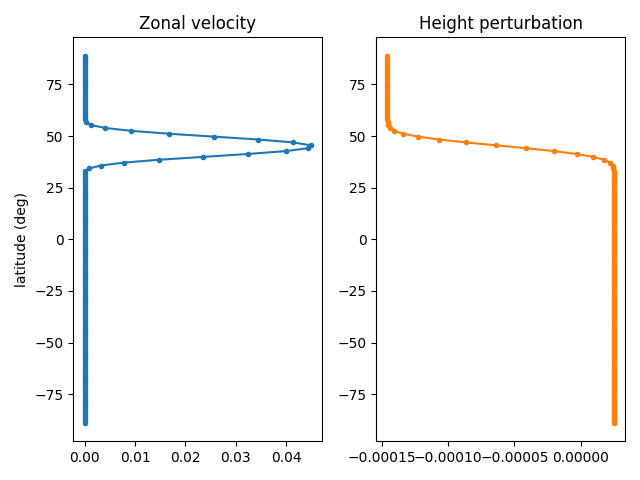

In [8]:
u0.change_scales(1)
h0.change_scales(1)

fig, ax = plt.subplots(1, 2)

ax[0].plot(u0['g'][0][0], lat[0] *180 /np.pi, '.-', color='C0')
ax[0].set_title('Zonal velocity')
ax[0].set_ylabel('latitude (deg)')

ax[1].plot(h0['g'][0], lat[0] *180 /np.pi, '.-', color='C1', label='height')
ax[1].set_title('Height perturbation')
plt.tight_layout();

## 3. Finding the most unstable mode (EVP)

Instead of prescribing a simple perturbation, we can use `Dedalus` to solve eigenvalue problems and identify the most unstable linear eigenmode of the balanced jet.
To do this, we create new fields representing perturbations to the jet and the eigenvalue, and then build an `EVP` by linearizing the equations around the background state.

We need to pass the eigenvalue field $\sigma$ to the `EVP` class during instantiation, and it can be used multiplicatively in the equations.

In [9]:
# Perturbation fields
u1 = dist.VectorField(coords, name='u1', bases=full_basis)
h1 = dist.Field(name='h1', bases=full_basis)
sigma = dist.Field(name='sigma')  # eigenvalue

# Parameters
nu = 1e5 *meter**2 /second /32**2 # Hyperdiffusion constant

# Eigenvalue problem
problem = d3.EVP([u1, h1], eigenvalue=sigma, namespace=locals())
problem.add_equation("sigma *u1 +u1 @grad(u0) +u0 @grad(u1) +nu *lap(lap(u1)) +g *grad(h1) +2 *Omega *zcross(u1) = 0")
problem.add_equation("sigma *h1 +div(h0 *u1) +div(h1 *u0) +nu *lap(lap(h1)) +H *div(u1) = 0");

The eigenvalue solver (like all solvers in `Dedalus`) decomposes the problem into linearly separable subproblems.
Each subproblem is represented by a separate matrix — these are constructed when a solver object is built, and together they form the diagonal blocks of the total linear system.
In this case, we have NCCs (the background flow) that depend on latitude, which means the system is linearly coupled across all $\ell$ for each $m$.

The eigenvalue solver then allows us to compute the eigenvalues for each subproblem independently.
The subproblems are stored as objects in the `solver.subproblems` list.
Each has a `.group` attribute describing the corresponding mode (wavenumber or spherical harmonic order/degree).
You can also use the `solver.subproblems_by_group` dictionary to access the object associated with a given horizontal mode — here in the form `(m, None)`, which indicates the matrices that couple all $\ell$ for a given $m$.

Finally, let’s loop over the subproblems and compute the fastest-growing mode for the first 15 spherical harmonic orders.

In [10]:
# Eigenvalue solver
m_max = 15
growth_rate = np.zeros(m_max +1)
solver = problem.build_solver()
for m in range(m_max +1):
    sp = solver.subproblems_by_group[(m, None)]
    solver.solve_dense(sp)
    growth_rate[m] = np.max(solver.eigenvalues.real)

/usr/local/lib/python3.12/dist-packages/scipy/sparse/_index.py:201: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


2025-10-22 15:24:39,590 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 6s, Remaining: 0s, Rate: 1.7e-01/s
2025-10-22 15:24:51,298 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 4.7e-01/s
2025-10-22 15:24:58,854 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 3s, Remaining: 0s, Rate: 3.8e-01/s
2025-10-22 15:25:06,403 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 4.5e-01/s
2025-10-22 15:25:13,561 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 3s, Remaining: 0s, Rate: 3.5e-01/s
2025-10-22 15:25:19,586 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 4.6e-01/s
2025-10-22 15:25:26,101 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 3s, Remaining: 0s, Rate: 3.5e-01/s
2025-10-22 15:25:31,860 subsystems 0/1 INFO :: Building subproblem matrices 

Now let's plot the growth rates:

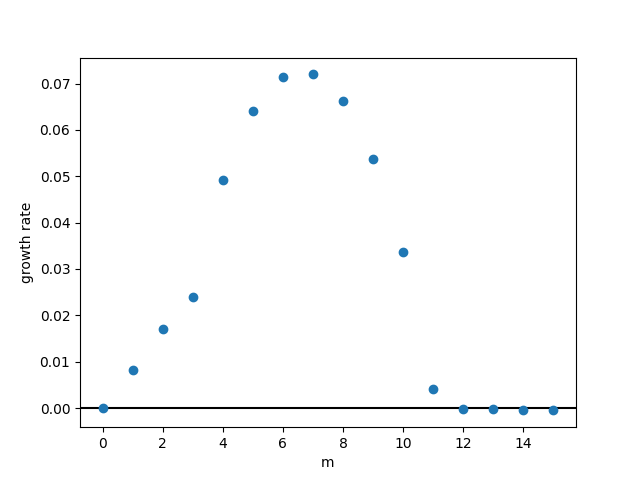

In [11]:
plt.figure()

plt.axhline(0, c='k')
plt.plot(np.arange(m_max +1), growth_rate, 'o')

plt.xlabel('m')
plt.ylabel('growth rate');

We see that the jet is unstable to a range of low $m$ perturbations, with the strongest instability occurring at $m = 7$.
We can then re-solve that subproblem and set the perturbation variables to the most unstable mode using the `solver.set_state` method:

In [12]:
sp = solver.subproblems_by_group[(7, None)]
solver.solve_dense(sp)
index = np.argmax(solver.eigenvalues.real)
solver.set_state(index, sp.subsystems[0])

/usr/local/lib/python3.12/dist-packages/dedalus/tools/array.py:353: ComplexWarning: Casting complex values to real discards the imaginary part
  dest[:] = src


Now we can plot e.g. the height perturbation in the eigenmode:

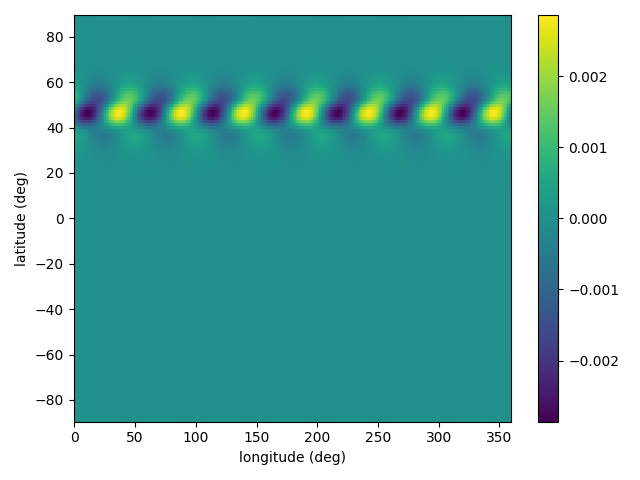

In [13]:
phi, theta = dist.local_grids(full_basis)

latitude = (np.pi /2 -theta) /np.pi *180
longitude = phi /np.pi *180

plt.figure()

plt.pcolormesh(longitude.ravel(), latitude.ravel(), h1['g'].T)

plt.xlabel('longitude (deg)')
plt.ylabel('latitude (deg)')
plt.colorbar()
plt.tight_layout();

# 4. Evolving the most unstable mode (IVP)

We now run a nonlinear `IVP`, initialized with the background jet and a small amplitude of the most unstable mode, in order to examine the saturation process.
To this end, we define new fields for the total variables and specify their initial conditions based on the background state and the fastest-growing mode.

In [14]:
# Full fields
u = dist.VectorField(coords, name='u', bases=full_basis)
h = dist.Field(name='h', bases=full_basis)

u0.change_scales(1)
u1.change_scales(1)
h0.change_scales(1)
h1.change_scales(1)

u['g'] = u0['g'] +1e-3 *u1['g']
h['g'] = h0['g'] +1e-3 *h1['g']

We now proceed to run the full forward simulation using the original nonlinear equation set:

In [15]:
# Timestepping parameters
timestep = 600 *second
stop_sim_time = 240 *hour

# Problem
problem = d3.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) +nu *lap(lap(u)) +g *grad(h) +2 *Omega *zcross(u) = -u @grad(u)")
problem.add_equation("dt(h) +nu *lap(lap(h)) +H *div(u) = -div(h *u)")

# Solver
solver = problem.build_solver(d3.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1 *hour)
snapshots.add_task(h, name='height')
snapshots.add_task(-d3.div(d3.skew(u)), name='vorticity')

# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration -1) % 100 == 0:
            logger.info(f'Iteration={solver.iteration:4d}, Time={solver.sim_time:e}, dt={timestep}')
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

2025-10-22 15:26:30,543 subsystems 0/1 INFO :: Building subproblem matrices 1/127 (~1%) Elapsed: 0s, Remaining: 5s, Rate: 2.7e+01/s
2025-10-22 15:26:30,798 subsystems 0/1 INFO :: Building subproblem matrices 13/127 (~10%) Elapsed: 0s, Remaining: 3s, Rate: 4.5e+01/s
2025-10-22 15:26:31,050 subsystems 0/1 INFO :: Building subproblem matrices 26/127 (~20%) Elapsed: 1s, Remaining: 2s, Rate: 4.8e+01/s
2025-10-22 15:26:31,325 subsystems 0/1 INFO :: Building subproblem matrices 39/127 (~31%) Elapsed: 1s, Remaining: 2s, Rate: 4.8e+01/s
2025-10-22 15:26:31,620 subsystems 0/1 INFO :: Building subproblem matrices 52/127 (~41%) Elapsed: 1s, Remaining: 2s, Rate: 4.7e+01/s
2025-10-22 15:26:31,935 subsystems 0/1 INFO :: Building subproblem matrices 65/127 (~51%) Elapsed: 1s, Remaining: 1s, Rate: 4.5e+01/s
2025-10-22 15:26:32,230 subsystems 0/1 INFO :: Building subproblem matrices 78/127 (~61%) Elapsed: 2s, Remaining: 1s, Rate: 4.5e+01/s
2025-10-22 15:26:32,535 subsystems 0/1 INFO :: Building subprobl

Finally, let’s create a movie of the solution using plotting tools from another script:

In [16]:
import matplotlib
from matplotlib import animation
from IPython.display import HTML
import h5py

# Plot parameters
task = 'vorticity'
cmap = plt.cm.RdBu_r
dpi = 100
figsize = (6, 6)

def build_s2_coord_vertices(phi, theta):
    phi = phi.ravel()
    phi_vert = np.concatenate([phi, [2 *np.pi]])
    phi_vert -= phi_vert[1] /2

    theta = theta.ravel()
    theta_mid = (theta[:-1] +theta[1:]) /2
    theta_vert = np.concatenate([[np.pi], theta_mid, [0]])

    return np.meshgrid(phi_vert, theta_vert, indexing='ij')

# Create figure
with h5py.File('snapshots/snapshots_s1.h5', mode='r') as file:

    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([0, 0, 1, 1], projection='3d')

    # Plot writes
    dset = file['tasks'][task]

    phi = dset.dims[1][0][:].ravel()
    theta = dset.dims[2][0][:].ravel()
    phi_vert, theta_vert = build_s2_coord_vertices(phi, theta)

    x = np.sin(theta_vert) *np.cos(phi_vert)
    y = np.sin(theta_vert) *np.sin(phi_vert)
    z = np.cos(theta_vert)

    data = dset[0]
    clim = np.max(np.abs(dset[:]))

    norm = matplotlib.colors.Normalize(-clim, clim)
    fc = cmap(norm(data))

    surf = ax.plot_surface(x, y, z, facecolors=fc, cstride=1, rstride=1, linewidth=0, antialiased=False, shade=False, zorder=5)

    ax.set_box_aspect((1, 1, 1))
    ax.set_xlim(-0.7, 0.7)
    ax.set_ylim(-0.7, 0.7)
    ax.set_zlim(-0.7, 0.7)
    ax.axis('off')

    def animate(i):
        data = dset[i]
        fc = cmap(norm(data))
        surf.set_facecolors(fc.reshape(fc.size //4, 4))

        return surf

    anim = animation.FuncAnimation(fig, animate, frames=dset.shape[0], interval=50, blit=False)
    video = HTML(anim.to_html5_video())

    plt.close(fig)

video.data = video.data.replace('autoplay', '')
video

2025-10-22 15:30:46,331 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-10-22 15:30:46,332 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 20.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp2zd750bf/temp.m4v
